In [1]:
import numpy as np
import nmp_util
import sympy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import sparse

In [2]:
data = pd.read_csv('serie4-observationsobs.sec', delimiter = r'\s+', names = ['I', 'z' , 's_z'], skiprows = [0])
display(data)

,I,z,s_z
1,0.05,27.0,3.6
2,0.10,59.0,5.4
3,0.15,146.0,8.5
4,0.17,183.0,7.8
5,0.20,228.0,10.7
6,0.22,228.0,10.7
7,0.25,268.0,9.5
8,0.27,268.5,8.8
9,0.30,277.0,11.8
10,0.32,283.5,11.9


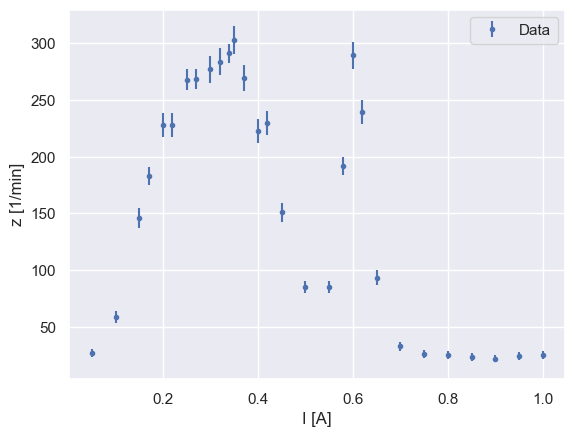

In [3]:
sns.set_theme()
plt.xlabel('I [A]')
plt.ylabel('z [1/min]')
plt.errorbar(data['I'], data['z'], data['s_z'], fmt='.', label = 'Data')
plt.legend()
plt.show()

# Define the functional model with sympy

In [4]:
a_0, a_1, a_2, sigma_1, sigma_2, mu_1, mu_2, I = sympy.symbols('a_0, a_1, a_2, sigma_1, sigma_2, mu_1, mu_2, I')

with sympy.evaluate(False):
    sqrt2pi = sympy.sqrt(2*sympy.pi)
    functional_model_expr = \
        a_1 / (sqrt2pi * sigma_1) * sympy.exp(-(I-mu_1)**2 / (2 * sigma_1**2)) +\
        a_2 / (sqrt2pi * sigma_2) * sympy.exp(-(I-mu_2)**2 / (2 * sigma_2**2)) + a_0

display(functional_model_expr)

a_0 + ((a_1/((sigma_1*sqrt(2*pi))))*exp((-(I - mu_1)**2)/((2*sigma_1**2))) + (a_2/((sigma_2*sqrt(2*pi))))*exp((-(I - mu_2)**2)/((2*sigma_2**2))))

Itaration: 1, m_0: 5.15
Itaration: 2, m_0: 2.42
Itaration: 3, m_0: 2.00
Itaration: 4, m_0: 1.99
Itaration: 5, m_0: 1.99
Itaration: 6, m_0: 1.99
Itaration: 7, m_0: 1.99
Itaration: 8, m_0: 1.99
Itaration: 9, m_0: 1.99
Itaration:10, m_0: 1.99
sigma_0 = 1
m_0 = 1.9870501831782674
sigma_0 / m_0 = 0.50
sigma = 1.99
degrees of freedom f = 22
parameters:


array([2.32548688e+01, 7.91245710e+01, 1.69971532e+01, 1.12614854e-01, 2.73968319e-02, 3.09340635e-01, 6.05751447e-01])

parameter covariance:


array([[ 6.89661893e+00, -4.05491915e+00, -6.43820741e-01, -3.68454839e-03, -6.11129637e-04,  2.92255616e-04, -3.31797726e-04],
       [-4.05491915e+00,  7.46145155e+00, -7.33723995e-02,  6.35501279e-03, -2.97610322e-04,  7.24198432e-04,  6.88542228e-04],
       [-6.43820741e-01, -7.33723995e-02,  1.18897467e+00, -7.17584401e-04,  8.46319835e-04, -7.12684280e-04,  2.15673935e-04],
       [-3.68454839e-03,  6.35501279e-03, -7.17584401e-04,  1.43712709e-05, -1.15259786e-06,  1.62584351e-06,  1.26888944e-06],
       [-6.11129637e-04, -2.97610322e-04,  8.46319835e-04, -1.15259786e-06,  3.17483670e-06, -1.06763624e-06,  2.15100706e-08],
       [ 2.92255616e-04,  7.24198432e-04, -7.12684280e-04,  1.62584351e-06, -1.06763624e-06,  1.44371141e-05,  7.88840237e-07],
       [-3.31797726e-04,  6.88542228e-04,  2.15673935e-04,  1.26888944e-06,  2.15100706e-08,  7.88840237e-07,  3.63386536e-06]])

,x,x_weight,y,y_pred,residuals,y_cov
0,0.05,0.077160,27.0,43.025442,16.025442,11.354726
1,0.10,0.034294,59.0,73.058973,14.058973,28.006208
2,0.15,0.013841,146.0,126.269597,-19.730403,46.602063
3,0.17,0.016437,183.0,153.626089,-29.373911,50.067068
4,0.20,0.008734,228.0,198.208049,-29.791951,51.283981
5,0.22,0.008734,228.0,227.880289,-0.119711,52.084562
6,0.25,0.011080,268.0,267.222772,-0.777228,57.082114
7,0.27,0.012913,268.5,286.964364,18.464364,62.256346
8,0.30,0.007182,277.0,302.594063,25.594063,67.176596
9,0.32,0.007062,283.5,302.303748,18.803748,66.041271


np.float64(1.9870501831782674)

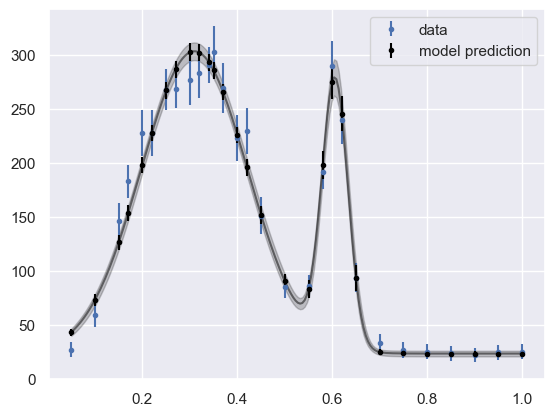

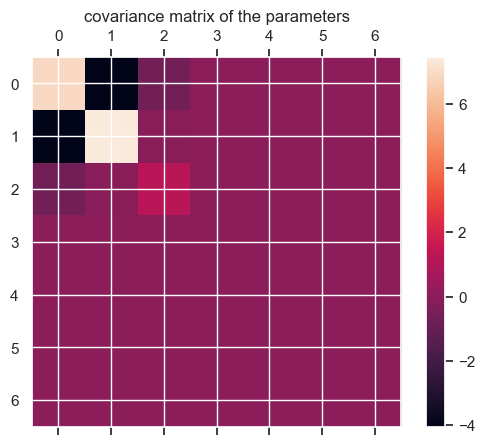

chi2 statistic : 86.86
critical values for 22 degrees of freedom
x(alpha = 0.10) = 30.81
x(alpha = 0.05) = 33.92
x(alpha = 0.01) = 40.29


In [5]:
weight_matrix = sparse.diags(1/data['s_z'].to_numpy()**2)

functional_model = nmp_util.SympyFunctionalModel(functional_model_expr, [a_0, a_1, a_2, sigma_1, sigma_2, mu_1, mu_2], I)

# the default values are given in the exercise, except for a_0, simply chose far a_0 too, and see if this converges
functional_model.set_parameters(np.array([50, 50, 50, 0.05, 0.05, 0.3, 0.6]))

functional_model.logger = lambda m : print(f'Itaration:{m.iterations:2d}, m_0: {m.m_0:.2f}')
functional_model.fit(data['I'], data['z'], weight_matrix)

functional_model.display_summary()